# Case Study: Exploratory Data Analysis
Please analyze the data linked below, and provide a report with your findings by Monday, 3/8/2021, along with any code you used (language of your choosing: SQL, R, Python, etc). Final reports can be 1-2 pages. We recommend spending 1-2 hours on this exercise.

## Context:
Ancestry helps customers to explore their family history through DNA products and through enabling family tree creation using an ACOM subscription. The analytics team is interested in predicting cross-sell from DNA products to ACOM subscriptions: **when a customer first purchases a DNA product and then later purchases an ACOM subscription.** To answer the question, a sample dataset of customers’ DNA product purchases and their cross-sell activity is provided below.

We consider a customer to be a cross sell (from DNA to ACOM subscription) when the following conditions are met in the data:
- xsell_gsa == 1. The customer became a new ACOM subscriber.
- xsell_day_exact <= 120. The customer purchased their ACOM subscription within 120 days of their DNA product order.

## Assignment:
As an intern, we would like you to assist a senior analyst investigating cross sell rate. The first step is exploratory data analysis. **Please provide summary your exploratory data analysis.** Do not worry about doing any of the modeling piece: assume you and the Sr. Analyst will work on this part later, but feel free to make recommendations if you wish.

See below for a detailed description of the dataset.
1. Perform any cleaning, exploratory analysis, and/or visualizations of the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed customers cross-sell to subscription?
2. Please provide a report with your exploratory data analysis, findings, and any recommendations. Assume this will be for your senior analyst colleague.

Data description:

| Column | Description |
| :----------- | :----------- |
| prospectid | Unique identifier for customers |
| ordernumber | Unique DNA order id |
| ordercreatedate | Date DNA product was ordered |
| regtenure | Days since the customer registered an email address with Ancestry |
| customer_type_group | Customer type at the time of the DNA order |
| dnatestactivationdayid | Date DNA test is activated. Customers must activate their kit by visiting the website after ordering for testing |
| daystogetresult_grp | Number of days taken for the DNA test results to be ready |
|dna_visittrafficsubtype| DNA Traffic visit channel, example: ‘Paid Search Non Brand’ |
| xsell_gsa | Indicates a new ACOM Subscriber Addition |
| xsell_day_exact | Days between DNA sale and ACOM subscription |

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Load the dataset
data = pd.read_csv('take-home_exercise_data.csv')

In [3]:
# Check the overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251942 entries, 0 to 251941
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               251942 non-null  int64  
 1   prospectid               251942 non-null  int64  
 2   ordernumber              251942 non-null  int64  
 3   ordercreatedate          251942 non-null  object 
 4   regtenure                251942 non-null  object 
 5   customer_type_group      251942 non-null  object 
 6   dnatestactivationdayid   178845 non-null  object 
 7   daystogetresult_grp      251942 non-null  object 
 8   dna_visittrafficsubtype  189093 non-null  object 
 9   xsell_gsa                251942 non-null  int64  
 10  xsell_day_exact          40579 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 21.1+ MB


<font color='blue'>__Here we can find that there is a meaningless column: `Unnamed: 0`. Since this column has no value to our EDA, so we need to remove it.__

In [4]:
#remove meaningless column
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
# Check the first 10 rows of the data
data.head(10)

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
0,93771712,127707306,2014-11-28,More than 120 days old,Existing Reg,2014-12-10,4 weeks,NaN,1,38.0
1,123112555,114401425,2013-12-05,Order prior to reg,New Reg,2014-01-13,4 weeks,NaN,1,40.0
2,171965960,159656050,2016-11-25,Order prior to reg,New Reg,NaN,-1,Paid Search Non Brand,0,NaN
3,175522116,165370285,2017-03-08,<=60 days,Existing Reg,NaN,-1,Email Programs,0,NaN
4,149288086,132837125,2015-03-30,Order prior to reg,New Reg,2015-04-06,4 weeks,NaN,0,NaN
5,58994698,101317667,2012-10-26,More than 120 days old,Acom Sub,2012-11-30,4 weeks,NaN,0,NaN
6,172404474,166005278,2017-03-19,<=120 days,Existing Reg,2017-03-26,-1,Email Programs,0,NaN
7,148805471,138025122,2015-08-07,More than 120 days old,Acom Sub,2015-08-20,6 weeks,email no source id,0,NaN
8,83821963,153455361,2016-07-14,More than 120 days old,Acom Sub,2016-07-28,6 weeks,direct non-homepage,0,NaN
9,109792034,160111092,2016-11-29,More than 120 days old,Existing Reg,2016-12-21,6 weeks,Email Campaigns,0,NaN


<font color='blue'>__Here we can find that there are NaNs in the dataset, two columns are `datetime`, column `xsell_gsa` is binary variable so it should be converted to object. `xsell_day_exact` is the number of days, so I convert it to integer.__

In [6]:
# Convert 'xsell_gsa' to object and xsell_day_exact to int
data.xsell_gsa = data.xsell_gsa.astype(str)
data.xsell_day_exact = data.xsell_day_exact.astype('Int64')

In [7]:
# Check the dimension of the new dataset, 251942 rows, 10 columns
data.shape

(251942, 10)

In [8]:
# Get descriptive statistics for numeric data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
prospectid,251942.0,1.144561e+08,5.277515e+07,760.0,71891435.0,124325420.5,1.649072e+08,179510511.0
ordernumber,251942.0,1.455821e+08,1.752503e+07,95923657.0,135645880.5,150413541.0,1.599612e+08,166736638.0
xsell_day_exact,40579.0,1.406740e+02,6.685883e+02,0.0,0.0,22.0,1.000000e+02,42302.0


<font color='blue'> __It's meaningless to get descriptive statistics for customer id (prospectid) and order number. Here I find out that the max of `xsell_day_exact` is 42302, which means the number of days between DNA sale and ACOM subscription is 42302 days (almost `118 yesrs`). So I think there are outliers in `xsell_day_exact` column.__

### Data Cleaning

In [9]:
# Check the number of NaNs in each column
data.isnull().sum()

# the '-1' in 'daystogetresult_grp' column also a form of missing value
num_na = data[data['daystogetresult_grp'] == '-1'].shape[0]
print('Number of missing value in "daystogetresult_grp":', num_na)

prospectid                      0
ordernumber                     0
ordercreatedate                 0
regtenure                       0
customer_type_group             0
dnatestactivationdayid      73097
daystogetresult_grp             0
dna_visittrafficsubtype     62849
xsell_gsa                       0
xsell_day_exact            211363
dtype: int64

Number of missing value in "daystogetresult_grp": 101965


<font color='blue'> __Usually what I treat NaNs is to remove them or replace them with means, modes, medians. We have 251,942 records in total but there is 211,360 NAs in `xsell_day_exact`, which means `84%` of the data in `xsell_day_exact` is NaN. In this case study, we only focus on EDA not modeling, other data contains many information, so I would keep the NaNs for now.__

<AxesSubplot:>

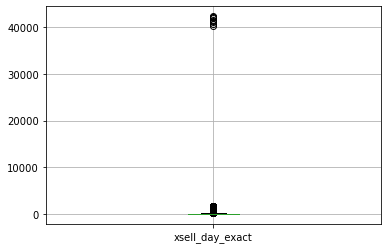

In [10]:
data.boxplot(column = ['xsell_day_exact'])
plt.show()

<font color='blue'> __It is clear that `xsell_day_exact` has outliers and most of them are around `40000`. Ancestry was found in 1996 and there are around 9000 days (25 years) in total since then. So days large than 9000 are incorrect data.__

In [11]:
# Identify outliers and find them
out_index = data[(data['xsell_day_exact'] >= 9000)].index
data.iloc[out_index]

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
3029,155297138,140337214,1900-01-01,No Reg Date,New Reg,2015-11-25,5 weeks,NaN,1,42231
4276,84408881,141609021,1900-01-01,No Reg Date,New Reg,2015-12-02,4 weeks,NaN,1,40578
7941,24456464,133526400,1900-01-01,No Reg Date,New Reg,2015-04-25,4 weeks,NaN,1,41485
96449,50140549,131986830,1900-01-01,No Reg Date,New Reg,2015-03-26,-1,NaN,1,42087
144280,106697222,132552046,1900-01-01,No Reg Date,New Reg,2015-03-30,4 weeks,NaN,1,41284
165863,102066828,142099849,1900-01-01,No Reg Date,New Reg,2015-11-27,>10weeks,NaN,1,42302
182913,147348606,137070982,1900-01-01,No Reg Date,New Reg,NaN,-1,NaN,1,42034
182985,12642581,130389156,1900-01-01,No Reg Date,New Reg,2015-02-08,5 weeks,NaN,1,40230
243767,94394792,134458593,1900-01-01,No Reg Date,New Reg,2015-05-16,3 weeks,NaN,1,41093


<font color='blue'> __From this partial dataframe, not only the data of `xsell_day_exact` is incorrect, but also the dates of `ordercreateddate` are incorrect. Let's find out how many wrong dates we have.__

In [12]:
# Identify outliers in dates and find them
out_index_date = data[(data['ordercreatedate'] <= '1996-01-01')].index
data.iloc[out_index_date]

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
3029,155297138,140337214,1900-01-01,No Reg Date,New Reg,2015-11-25,5 weeks,NaN,1,42231
4276,84408881,141609021,1900-01-01,No Reg Date,New Reg,2015-12-02,4 weeks,NaN,1,40578
7941,24456464,133526400,1900-01-01,No Reg Date,New Reg,2015-04-25,4 weeks,NaN,1,41485
12833,158981531,143367592,1900-01-01,No Reg Date,New Reg,NaN,-1,NaN,0,<NA>
61488,151633694,134016837,1900-01-01,No Reg Date,New Reg,NaN,-1,NaN,0,<NA>
73340,162579443,146559202,1900-01-01,No Reg Date,New Reg,2016-04-04,6 weeks,NaN,0,<NA>
96449,50140549,131986830,1900-01-01,No Reg Date,New Reg,2015-03-26,-1,NaN,1,42087
144280,106697222,132552046,1900-01-01,No Reg Date,New Reg,2015-03-30,4 weeks,NaN,1,41284
165863,102066828,142099849,1900-01-01,No Reg Date,New Reg,2015-11-27,>10weeks,NaN,1,42302
182913,147348606,137070982,1900-01-01,No Reg Date,New Reg,NaN,-1,NaN,1,42034


In [13]:
# Check the date range of 'ordercreatedate' and 'dnatestactivationdayid'
date_col = ['ordercreatedate','dnatestactivationdayid']

# Firstly change the datatype to datetime, otherwise it gives an error due to NaN.
for col in date_col:
    data[col] = pd.to_datetime(data[col])
    print('Date range:', data[col].max(), data[col].min())

Date range: 2017-04-02 00:00:00 1900-01-01 00:00:00
Date range: 2017-04-03 00:00:00 2012-05-10 00:00:00


<font color='blue'> __Here we can see the test `activate date` range is normal, but the `order date` has incorrect data (minimum date is 1900-01-01, which is impossible). So I need to remove the incorrect data.__

In [14]:
# Remove incorrect data of 'ordercreatedate' and 'xsell_day_exact'
data.drop(out_index_date, inplace = True)
data.shape

(251930, 10)

<font color='blue'> __Now the incorrect data is removed. But we need to double check using histogram.__

<AxesSubplot:>

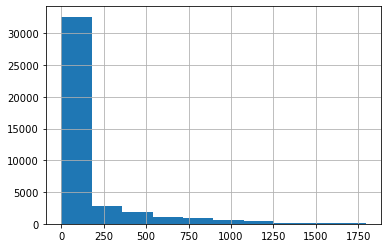

In [15]:
data['xsell_day_exact'].hist()

<font color='blue'> __It shows that most of the customers subscribe ACOM within 250 days after they purchased DNA product.__

In [16]:
for col in date_col:
    data[col] = pd.to_datetime(data[col])
    print('Date range:', data[col].max(), data[col].min())

Date range: 2017-04-02 00:00:00 2012-05-04 00:00:00
Date range: 2017-04-03 00:00:00 2012-05-10 00:00:00


<font color='blue'> __Dates look normal now.__

### Categorical Data Investigation

In [17]:
# Get the number of records for each levels in categorical data
for col in data.columns:
    if data[col].dtypes == 'O':
        print(data[col].value_counts())

More than 120 days old    148440
Order prior to reg         80058
<=10 days                   6562
<=60 days                   5156
<=90 days                   3629
<=120 days                  2928
<=20 day                    2384
<=30 days                   1976
No Reg Date                  797
Name: regtenure, dtype: int64
Existing Reg    90773
Acom Sub        81253
New Reg         79904
Name: customer_type_group, dtype: int64
-1          101961
4 weeks      32451
5 weeks      32233
6 weeks      30620
3 weeks      25184
7 weeks      10876
>10weeks      4052
8 weeks       3910
2 weeks       3613
9 weeks       3475
10 weeks      3352
1 week         203
Name: daystogetresult_grp, dtype: int64
direct core homepage                        39719
paid search – dna brand                     20905
Email Campaigns                             20081
Paid Search Non Brand                       13400
internal referrals                          12296
direct non-homepage                         12288

Text(1, -18, '148440')

Text(1, -18, '80058')

Text(1, -18, '6562')

Text(1, -18, '5156')

Text(1, -18, '3629')

Text(1, -18, '2928')

Text(1, -18, '2384')

Text(1, -18, '1976')

Text(1, -18, '797')

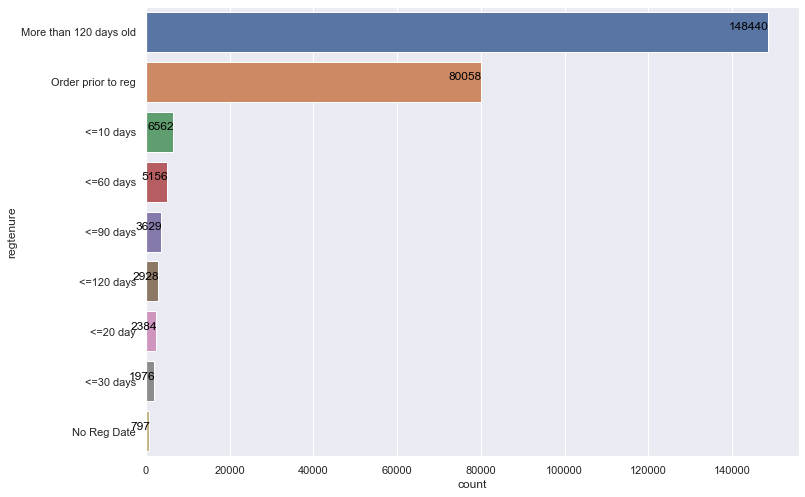

Text(1, -18, '90773')

Text(1, -18, '81253')

Text(1, -18, '79904')

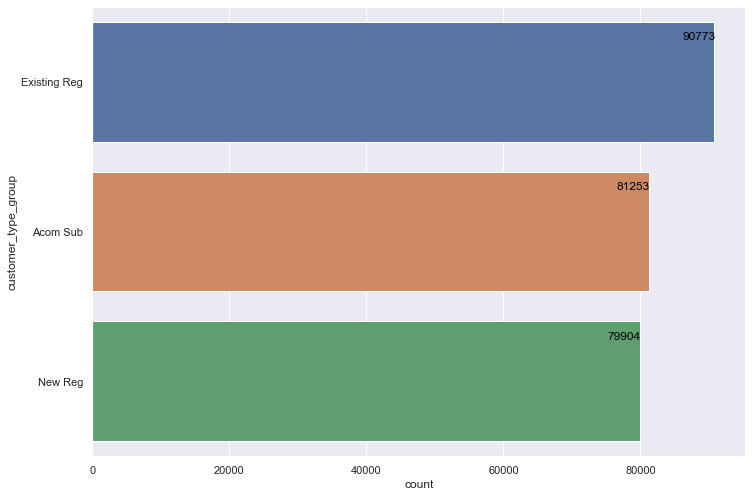

Text(1, -18, '101961')

Text(1, -18, '32451')

Text(1, -18, '32233')

Text(1, -18, '30620')

Text(1, -18, '25184')

Text(1, -18, '10876')

Text(1, -18, '4052')

Text(1, -18, '3910')

Text(1, -18, '3613')

Text(1, -18, '3475')

Text(1, -18, '3352')

Text(1, -18, '203')

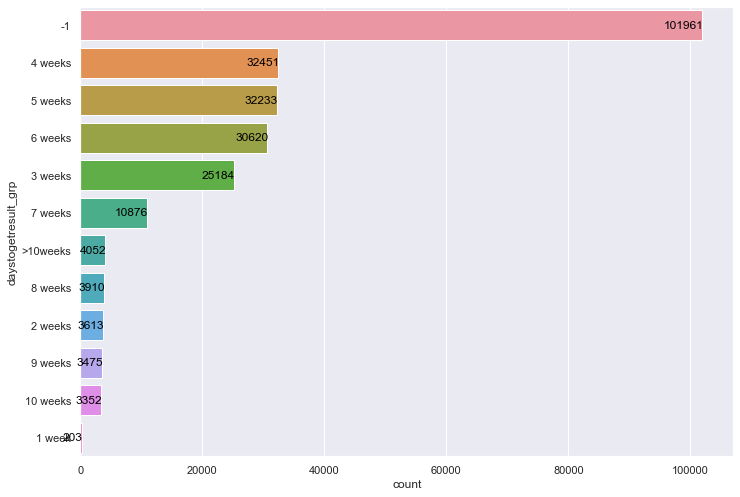

Text(1, -18, '39719')

Text(1, -18, '20905')

Text(1, -18, '20081')

Text(1, -18, '13400')

Text(1, -18, '12296')

Text(1, -18, '12288')

Text(1, -18, '10425')

Text(1, -18, '9205')

Text(1, -18, '8642')

Text(1, -18, '7610')

Text(1, -18, '6693')

Text(1, -18, '6341')

Text(1, -18, '4911')

Text(1, -18, '4066')

Text(1, -18, '3569')

Text(1, -18, '1536')

Text(1, -18, '1534')

Text(1, -18, '1348')

Text(1, -18, '1114')

Text(1, -18, '1101')

Text(1, -18, '807')

Text(1, -18, '355')

Text(1, -18, '269')

Text(1, -18, '167')

Text(1, -18, '155')

Text(1, -18, '108')

Text(1, -18, '92')

Text(1, -18, '67')

Text(1, -18, '63')

Text(1, -18, '37')

Text(1, -18, '37')

Text(1, -18, '30')

Text(1, -18, '30')

Text(1, -18, '26')

Text(1, -18, '13')

Text(1, -18, '12')

Text(1, -18, '9')

Text(1, -18, '9')

Text(1, -18, '6')

Text(1, -18, '5')

Text(1, -18, '3')

Text(1, -18, '3')

Text(1, -18, '2')

Text(1, -18, '2')

Text(1, -18, '1')

Text(1, -18, '1')

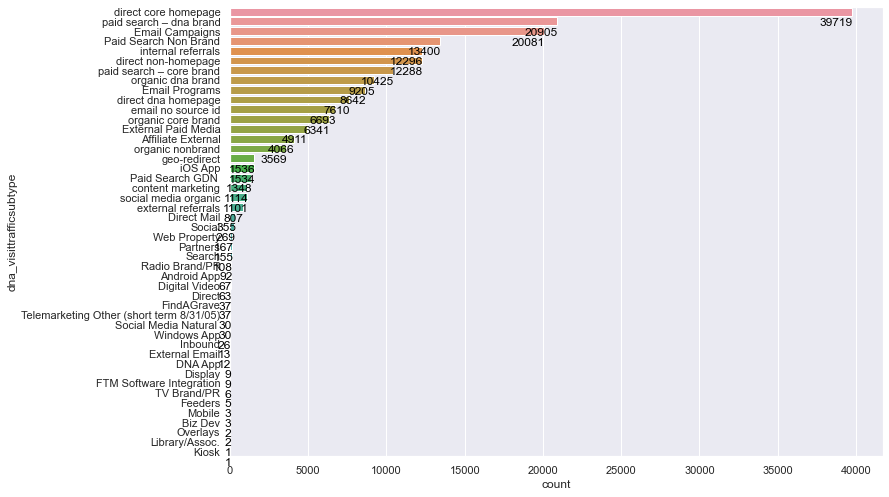

Text(1, -18, '211360')

Text(1, -18, '40570')

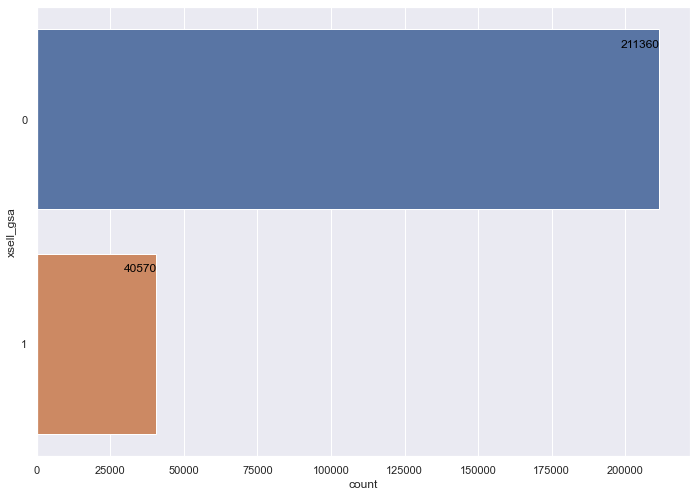

In [18]:
# Visualize the values for each levels in categorical data
traffic = data["dna_visittrafficsubtype"].dropna()
traffic = pd.DataFrame(traffic)

sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

for col in data.columns:
    if data[col].dtypes == 'O':
        ax = sns.countplot(y = col, data = data,order = data[col].value_counts().index)
        for p in ax.patches:
            ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(1, -18),fontsize=12,color='black',textcoords='offset points', horizontalalignment='right')
        plt.show()

<font color='blue'> __From these plots, we can know the descending number of records for each levels in each category from high to low visually.__

<AxesSubplot:xlabel='customer_type_group', ylabel='count'>

<AxesSubplot:xlabel='regtenure', ylabel='count'>

<AxesSubplot:xlabel='daystogetresult_grp', ylabel='count'>

<AxesSubplot:xlabel='count', ylabel='dna_visittrafficsubtype'>

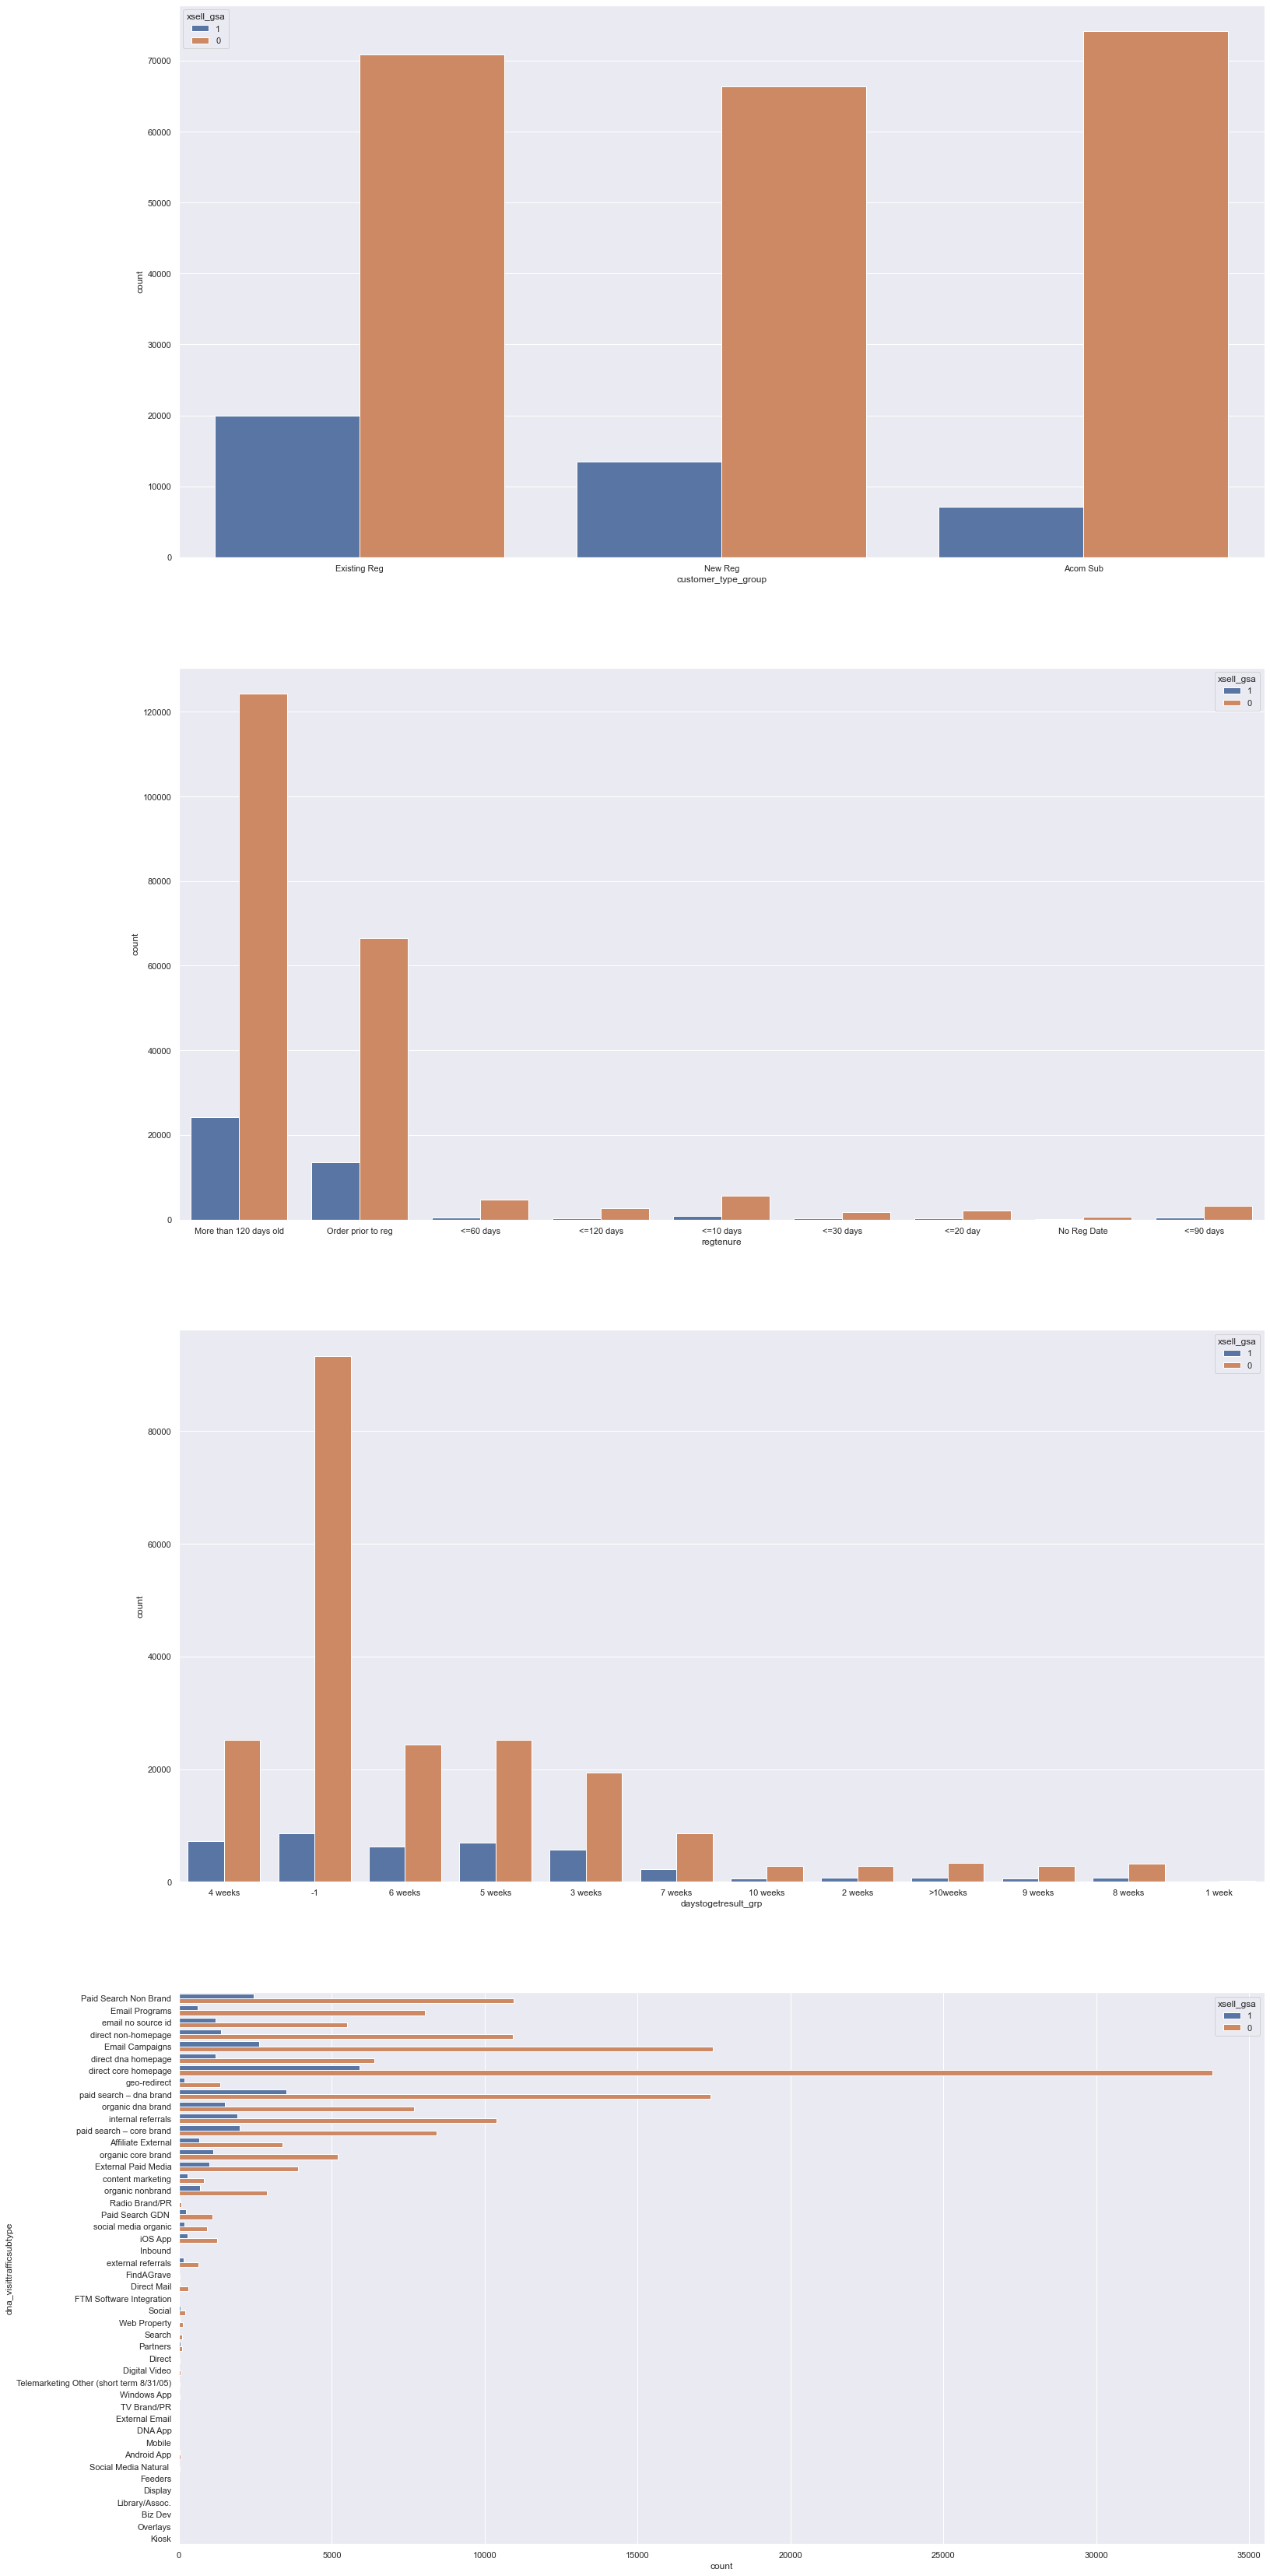

In [19]:
fig, axarr = plt.subplots(4,figsize=(25, 60))
sns.countplot(x='customer_type_group', hue = 'xsell_gsa',data = data, ax=axarr[0])
sns.countplot(x='regtenure', hue = 'xsell_gsa',data = data, ax=axarr[1])
sns.countplot(x='daystogetresult_grp', hue = 'xsell_gsa',data = data, ax=axarr[2])
sns.countplot(y='dna_visittrafficsubtype', hue = 'xsell_gsa',data = data, ax=axarr[3])

<font color='blue'> __These plots focus on the comparisons of ACOM subscribers and non-subscribers in customer types, result ready days, registration days, and traffic sources.__

### Orders Analysis

<font color='blue'> __Please see Tableau file.__

### What fraction of the observed customers cross-sell to subscription?
Cross-sell (from DNA to ACOM subscription) :
- xsell_gsa == 1. The customer became a new ACOM subscriber.
- xsell_day_exact <= 120. The customer purchased their ACOM subscription within 120 days of their DNA product order.

In [20]:
# Filter the data which satisfies the cross-sell conditions
cross_sell = data[(data['xsell_gsa'] == '1') & (data['xsell_day_exact'] <= 120.0)]

# Get the total records of cross-sell
print('Cross-sell:',cross_sell.shape[0])

# Total number of customers, exclude incorrect data
print('Non Cross-sell:',data.shape[0]-cross_sell.shape[0])

Cross-sell: 31216
Non Cross-sell: 220714


([<matplotlib.patches.Wedge at 0x7ffa65675a30>,
 [Text(1.017706372850417, 0.41746106244732395, 'Cross-sell'),
  Text(-1.110225155338013, -0.45541201615096316, 'Non Cross-sell')],
 [Text(0.5551125670093182, 0.22770603406217668, '12.4%'),
  Text(-0.6476313406138409, -0.26565700942139514, '87.6%')])

(-1.2015284339279546,
 1.1048346873299026,
 -1.1445481037277363,
 1.069207560594367)

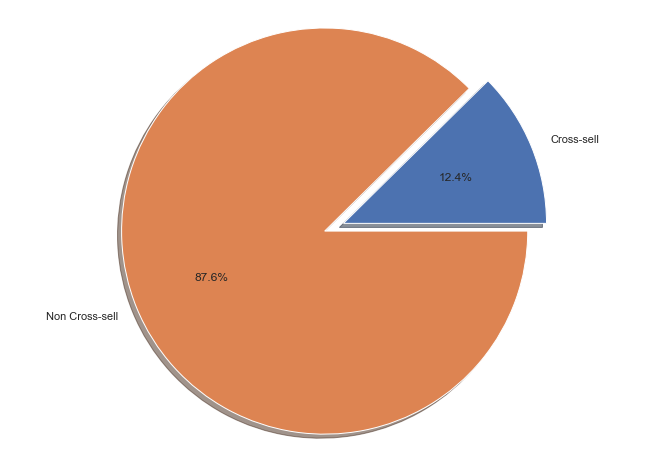

In [21]:
labels = ['Cross-sell', 'Non Cross-sell']
sizes = [cross_sell.shape[0], data.shape[0]-cross_sell.shape[0]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, explode = [0,0.1], autopct='%1.1f%%', shadow=True)
ax.axis('equal')
plt.show()

<font color='blue'> __The fraction of the observed customers cross-sell to subscription is `12.4%`__